In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.manifold import Isomap

import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score


from sklearn.svm import SVC


import cv2 as cv2
from skimage.color import rgb2gray
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.filters import gabor_kernel
from skimage import img_as_float32


from keras.preprocessing.image import ImageDataGenerator


from scipy import signal as sg

In [2]:
train = pd.read_csv('mnist_train.csv')
test  = pd.read_csv('mnist_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


# Preprocessing

In [3]:
encoder = OneHotEncoder()

train_target = train['label']
test_target = test['label']

train_values = train.drop('label', axis=1)
test_values = test.drop('label', axis=1)

train_values = train_values.values.reshape(-1, 28, 28) 
test_values = test_values.values.reshape(-1, 28, 28)

train_target_encoded = encoder.fit_transform(train_target.values.reshape(-1, 1)).toarray()
test_target_encoded = encoder.transform(test_target.values.reshape(-1, 1)).toarray()

print("Shape of train_values:", train_values.shape)
print("Shape of train_target_encoded:", train_target_encoded.shape)

print("Shape of test_values:", test_values.shape)
print("Shape of test_target_encoded:", test_target_encoded.shape)

Shape of train_values: (60000, 28, 28)
Shape of train_target_encoded: (60000, 10)
Shape of test_values: (10000, 28, 28)
Shape of test_target_encoded: (10000, 10)


In [4]:
X_train = train_values
X_train = train_values.astype(np.uint8)

y_train_ENC = train_target_encoded
y_train = np.argmax(y_train_ENC, axis=1)

X_test = test_values
X_test = test_values.astype(np.uint8)

y_test_ENC = test_target_encoded
y_test = np.argmax(y_test_ENC, axis=1)

In [5]:
# Sprawdzenie i konwersja typu danych
if X_train.dtype != np.uint8:
    X_train = X_train.astype(np.uint8)
if X_test.dtype != np.uint8:
    X_test = X_test.astype(np.uint8)

# Sprawdzenie i ewentualna korekta kształtu danych
if X_train.shape[1:] != (28, 28):
    X_train = X_train.reshape(-1, 28, 28)
if X_test.shape[1:] != (28, 28):
    X_test = X_test.reshape(-1, 28, 28)

# Wyrównywanie histogramu
for i in range(X_train.shape[0]):
    X_train[i] = cv2.equalizeHist(X_train[i])

for i in range(X_test.shape[0]):
    X_test[i] = cv2.equalizeHist(X_test[i])

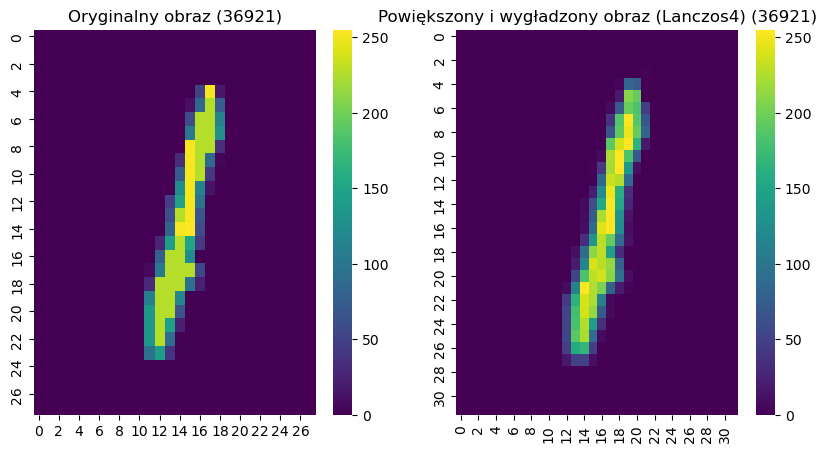

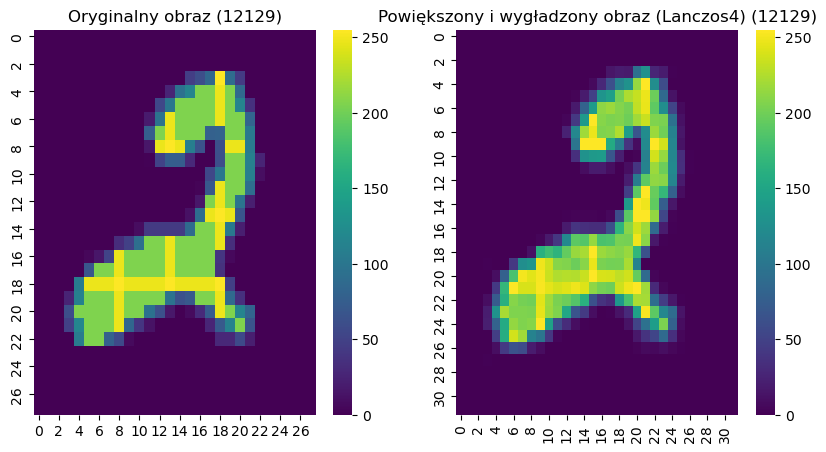

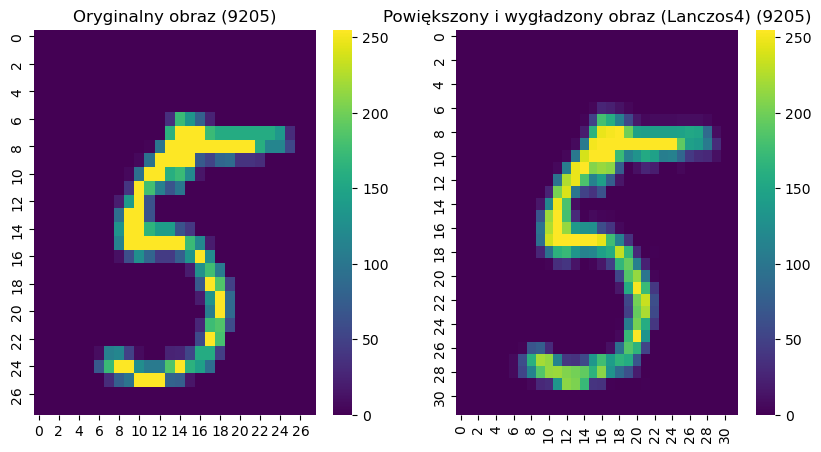

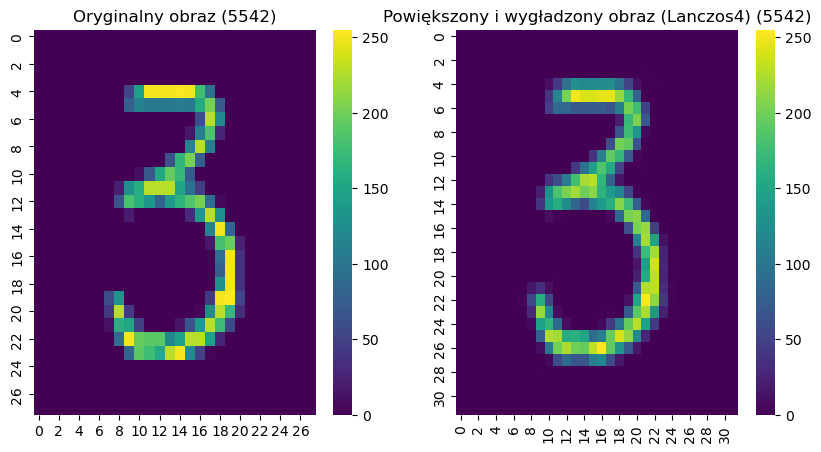

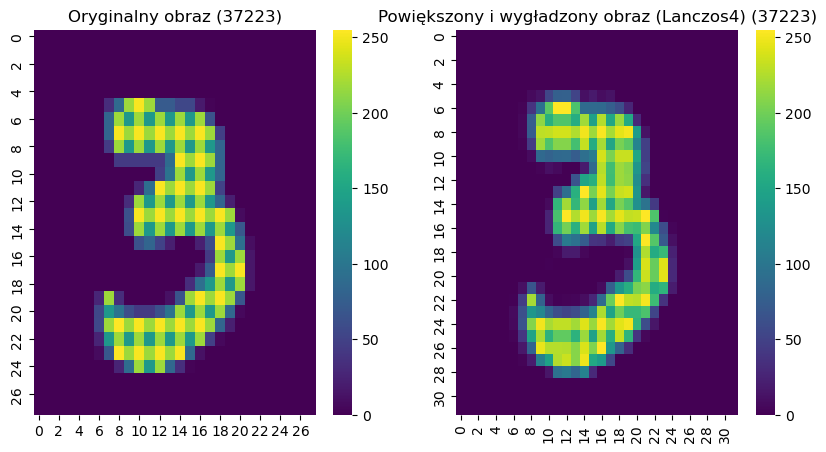

In [6]:
def enlarge_and_smooth(image, new_size):
    """Powiększa obraz za pomocą interpolacji bicubic."""
    enlarged_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return enlarged_image

# Sztuczne zwiększenie rozmiaru obrazu 
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

# Dla każdego wybranego obrazu
for idx in sample_indices:
    # Oryginalny obraz
    original_image = X_train[idx]

    # Powiększony i wygładzony obraz
    enlarged_smoothed_image = enlarge_and_smooth(original_image, new_size=(32, 32))  # Przykładowy nowy rozmiar

    # Wyświetl oryginalny i przekształcony obraz obok siebie
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.heatmap(original_image, cmap="viridis", ax=axes[0])
    axes[0].set_title(f'Oryginalny obraz ({idx})')

    sns.heatmap(enlarged_smoothed_image, cmap="viridis", ax=axes[1])
    axes[1].set_title(f'Powiększony i wygładzony obraz (Lanczos4) ({idx})')

    plt.show()

In [7]:
# # Baseline accuracy without transformations
# X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

# qda_base = QDA()
# qda_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for QDA
# y_pred_qda_base = qda_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_qda_base = accuracy_score(y_val_base, y_pred_qda_base)

# svm_base = SVC()
# svm_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for SVM
# y_pred_svm_base = svm_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_svm_base = accuracy_score(y_val_base, y_pred_svm_base)

# print("Baseline QDA accuracy:", accuracy_qda_base)
# print("Baseline SVM accuracy:", accuracy_svm_base)

#### Baseline QDA accuracy: 0.5525
#### Baseline SVM accuracy: 0.9793

## Deklaracja funkcji filtru Gabora, oraz H.O.G 

In [8]:
orientations = 9 
pixels_per_cell = '(8, 8)'
cells_per_block='(2, 2)'

def calculate_hog(image, orientations=orientations, pixels_per_cell= pixels_per_cell, cells_per_block=cells_per_block):
    """Oblicza deskryptory HOG dla obrazu."""

    # Konwersja na skalę szarości, jeśli obraz jest wielokanałowy
    if len(image.shape) > 2:
        image = rgb2gray(image)

    # Upewnienie się, że obraz jest typu float32 w zakresie [0, 1]
    image = img_as_float32(image)

    # Konwersja ciągów znaków na listy

    pixels_per_cell = eval(pixels_per_cell)
    cells_per_block = eval(cells_per_block)

    fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                 cells_per_block=cells_per_block, visualize=False, channel_axis=None) 

    return fd

thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
sigmas = [1, 3]
frequencies = [0.05, 0.25] 

def apply_gabor_filters(image, thetas = thetas, sigmas = sigmas , frequencies = frequencies):
    """Stosuje filtry Gabora do obrazu."""
      
    kernels = []
    for theta in thetas:
        for sigma in sigmas:
            for frequency in frequencies:
                kernel = np.real(gabor_kernel(frequency, theta=theta,
                                               sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel) 


    filtered_images = []
    for kernel in kernels:
        filtered = sg.convolve2d(image, kernel, mode='valid')
        filtered_images.append(filtered)

    #maksymalne wymiary
    max_height = max(img.shape[0] for img in filtered_images)
    max_width = max(img.shape[1] for img in filtered_images)

    #zera do maksymalnych wymiarów
    padded_images = []
    for img in filtered_images:
        pad_height = max_height - img.shape[0]
        pad_width = max_width - img.shape[1]
        padded_img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant')
        padded_images.append(padded_img)

    result = np.array(padded_images).squeeze()
    #print(f'Kształt obrazu po filtrach Gabora: {result.shape}')

    return result

# # UWzględnienie części urojonej i dodanie jej do wspólnych cech. 
# def apply_gabor_filters(image, thetas = thetas, sigmas = sigmas , frequencies = frequencies):
#     """Stosuje filtry Gabora do obrazu."""

#     kernels = []
#     for theta in thetas:
#         for sigma in sigmas:
#             for frequency in frequencies:
#                 kernel = np.real(gabor_kernel(frequency, theta=theta,
#                                                sigma_x=sigma, sigma_y=sigma))
#                 kernels.append(kernel) 


#     filtered_images = []
#     for kernel in kernels:
#         filtered = sg.convolve2d(image, kernel, mode='valid')
#         # Dodajemy zarówno część rzeczywistą, jak i urojoną do listy, spłaszczając je
#         filtered_images.append(np.real(filtered).flatten())
#         filtered_images.append(np.imag(filtered).flatten())

#     # Znajdź maksymalne wymiary (teraz dla spłaszczonych wektorów)
#     max_length = max(img.shape[0] for img in filtered_images)

#     # Uzupełnij wektory zerami do maksymalnej długości
#     padded_images = []
#     for img in filtered_images:
#         pad_length = max_length - img.shape[0]
#         padded_img = np.pad(img, (0, pad_length), mode='constant')
#         padded_images.append(padded_img)

#     result = np.array(padded_images).squeeze()

#     return result

### Ekstrakcja cech i trenowanie modelu

In [9]:
# def extract_features_and_train(X_train, y_train):

#     # Ekstrakcja cech HOG i Gabor
#     X_train_features = np.array([np.concatenate([
#         calculate_hog(img),
#         apply_gabor_filters(img).flatten()
#     ]) for img in X_train])

#     # Podział na zbiór treningowy i walidacyjny
#     X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)

#     # Tworzenie i trenowanie modelu QDA
#     qda = QDA()
#     qda.fit(X_train, y_train)
    
#     # Tworzenie i trenowanie modelu SVC
#     svc = SVC()
#     svc.fit(X_train, y_train)

#     # Ocena modelu
#     y_pred_QDA = qda.predict(X_val)
#     accuracy_QDA = accuracy_score(y_val, y_pred_QDA)
    
#     y_pred_svc = svc.predict(X_val)
#     accuracy_svc = accuracy_score(y_val, y_pred_svc)
    
#     print("Dokładność QDA HOG i Gabor:", accuracy_QDA)
#     print("Dokładność SVC HOG i Gabor:", accuracy_svc)

# extract_features_and_train(X_train, y_train)

#### Dokładność QDA HOG i Gabor: 0.47725
#### Dokładność SVC HOG i Gabor: 0.97633

### Szybkie sprawdzenie czy PCA poprawi wyniki

In [10]:
# # # 3. Ekstrakcja cech i trenowanie modelu
# def extract_features_and_train(X_train, y_train):

#     # Ekstrakcja cech HOG i Gabor
#     X_train_features = np.array([np.concatenate([
#         calculate_hog(img),
#         apply_gabor_filters(img).flatten()
#     ]) for img in X_train])

#     # Podział na zbiór treningowy i walidacyjny
#     X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)
#     # Redukcja wymiarów za pomocą Isomap
#     PCA_DIM = PCA(n_components=50)  
#     X_train_reduced = PCA_DIM.fit_transform(X_train)
#     X_val_reduced = PCA_DIM.transform(X_val) 

#     # Tworzenie i trenowanie modelu QDA
#     qda = QDA()
#     qda.fit(X_train_reduced, y_train)

#     # Tworzenie i trenowanie modelu SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train_reduced, y_train)

#     # Ocena modelu
#     y_pred_QDA = qda.predict(X_val_reduced)
#     accuracy_QDA = accuracy_score(y_val, y_pred_QDA)

#     y_pred_svc = svc.predict(X_val_reduced)
#     accuracy_svc = accuracy_score(y_val, y_pred_svc)

#     print("Dokładność QDA HOG i Gabor po PCA:", accuracy_QDA)
#     print("Dokładność SVC HOG i Gabor po PCA:", accuracy_svc)

# extract_features_and_train(X_train, y_train)

#### Dokładność QDA HOG i Gabor po PCA : 0.9585
#### Dokładność SVC HOG i Gabor po PCA: 0.98225

### OPTUNA dla HOG, Gabor, PCA

In [11]:
# import warnings
# warnings.filterwarnings("ignore", module="optuna")


# def objective(trial, X_train, y_train):
#     """
#     Funkcja celu dla optymalizacji Optuna. 
#     Przyjmuje próbę (trial), dane treningowe (X_train) i etykiety (y_train).
#     Zwraca dokładność QDA i SVM na danych walidacyjnych po zastosowaniu sekwencji transformacji.
#     """
#     # Podział danych na treningowe i walidacyjne
#     X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

#     # Parametry HOG
#     hog_orientations        = trial.suggest_int("hog_orientations", 2, 16)
#     hog_pixels_per_cell_str = trial.suggest_categorical("hog_pixels_per_cell", [str((2, 2)), str((2, 3)), str((3, 2)), str((3, 3)), str((4, 4)), str((5, 5)),str((6, 6)), str((7, 7))])
#     hog_cells_per_block_str = trial.suggest_categorical("hog_cells_per_block", [str((1, 1)), str((2, 2)), str((3, 3)), str((4, 4))])

#     # Parametry filtrów Gabora
#     gabor_thetas = trial.suggest_categorical("gabor_thetas", ([0],  [np.pi / 14],  [np.pi / 12], [0, np.pi / 14 ], [0, np.pi / 12 ] ))
#     gabor_sigmas = trial.suggest_categorical("gabor_sigmas", ([0.33], [0.66], [1], [0.33 , 1.25], [0.66, 2.35], [1, 3]))
#     gabor_frequencies = trial.suggest_categorical("gabor_frequencies", ([0.025], [0.05], [0.125], [0.025, 0.125], [0.05, 0.175], [0.05, 0.25]))
        
#     #PCA
#     PCA_n_components  =  trial.suggest_int("PCA_Components", 4, 228)
    
#     # Ekstrakcja cech HOG
#     X_train_hog = np.array([calculate_hog(img, 
#                                           orientations=hog_orientations, 
#                                           pixels_per_cell=hog_pixels_per_cell_str, 
#                                           cells_per_block=hog_cells_per_block_str) for img in X_train_split])
#     X_val_hog = np.array([calculate_hog(img, 
#                                         orientations=hog_orientations, 
#                                         pixels_per_cell=hog_pixels_per_cell_str, 
#                                         cells_per_block=hog_cells_per_block_str) for img in X_val])

#     # Ekstrakcja cech Gabora
#     X_train_gabor = np.array([apply_gabor_filters(img, gabor_thetas, gabor_sigmas, gabor_frequencies) for img in X_train_split])
#     X_val_gabor = np.array([apply_gabor_filters(img, gabor_thetas, gabor_sigmas, gabor_frequencies) for img in X_val])

#     # Spłaszczenie i połączenie cech
#     X_train_combined = np.hstack([X_train_hog, X_train_gabor.reshape(X_train_gabor.shape[0], -1)])
#     X_val_combined = np.hstack([X_val_hog, X_val_gabor.reshape(X_val_gabor.shape[0], -1)])
    
#     #PCA
#     PCA_Dim = PCA(n_components=PCA_n_components)  
#     X_train_reduced = PCA_Dim.fit_transform(X_train_combined)
#     X_val_reduced = PCA_Dim.transform(X_val_combined) 

#     # # QDA
#     # qda = QDA()
#     # qda.fit(X_train_reduced, y_train_split)
#     # y_pred_qda = qda.predict(X_val_reduced)
#     # accuracy_qda = accuracy_score(y_val, y_pred_qda)                                    

#     # SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train_reduced, y_train_split)
#     y_pred_svm = svc.predict(X_val_reduced)
#     accuracy_svm = accuracy_score(y_val, y_pred_svm)

#     return accuracy_svm 

# # Uruchomienie optymalizacji                                   
# study = optuna.create_study(directions=["maximize"]) 
# study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, n_jobs=2)

# # Wyświetlenie wyników
# print("Best parameters:", study.best_params)
# print("Best QDA accuracy:", study.best_trial.values[0]) 
# print("Best SVM accuracy:", study.best_trial.values[1]) 

# #[I 2024-09-04 19:06:10,402] Trial 1 finished with values: [0.9229, 0.98308] and parameters: {'hog_orientations': 3, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0], 'gabor_sigmas': [0.66], 'gabor_frequencies': [0.05], 'PCA_Components': 208}. 
# #[I 2024-09-04 19:20:04,928] Trial 4 finished with values: [0.9585, 0.98291] and parameters: {'hog_orientations': 11, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(1, 1)', 'gabor_thetas': [0], 'gabor_sigmas': [0.66], 'gabor_frequencies': [0.05, 0.175], 'PCA_Components': 46}. 
# #[I 2024-09-05 09:39:00,822] Trial 46 finished with value: 0.9834166666666667 and parameters: {'hog_orientations': 7, 'hog_pixels_per_cell': '(7, 7)', 'hog_cells_per_block': '(1, 1)', 'gabor_thetas': [0, 0.2243994752564138], 'gabor_sigmas': [0.66], 'gabor_frequencies': [0.025], 'PCA_Components': 96}. Best is trial 46 with value: 0.9834166666666667.
# #[I 2024-09-05 10:03:49,573] Trial 57 finished with value: 0.9834166666666667 and parameters: {'hog_orientations': 15, 'hog_pixels_per_cell': '(3, 3)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0, 0.2243994752564138], 'gabor_sigmas': [0.66], 'gabor_frequencies': [0.025], 'PCA_Components': 109}. Best is trial 46 with value: 0.9834166666666667.

In [12]:
# import warnings
# warnings.filterwarnings("ignore", module="optuna")

# new_size=(54, 54)

# def objective(trial, X_train, y_train):
#     """
#     Funkcja celu dla optymalizacji Optuna. 
#     Przyjmuje próbę (trial), dane treningowe (X_train) i etykiety (y_train).
#     Zwraca dokładność QDA i SVM na danych walidacyjnych po zastosowaniu sekwencji transformacji.
#     """
    
#     # Podział danych na treningowe i walidacyjne
#     X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

#     # Parametry HOG
#     hog_orientations        = trial.suggest_int("hog_orientations", 2, 16)
#     hog_pixels_per_cell_str = trial.suggest_categorical("hog_pixels_per_cell", [str((2, 2)), str((2, 3)), str((3, 2)), str((3, 3)), str((4, 4)), str((5, 5)),str((6, 6)), str((7, 7))])
#     hog_cells_per_block_str = trial.suggest_categorical("hog_cells_per_block", [str((1, 1)), str((2, 2)), str((3, 3)), str((4, 4))])

#     # Parametry filtrów Gabora
#     gabor_thetas = trial.suggest_categorical("gabor_thetas", ([0],  [np.pi / 14],  [np.pi / 12], [0, np.pi / 14 ], [0, np.pi / 12 ] ))
#     gabor_sigmas = trial.suggest_categorical("gabor_sigmas", ([0.33], [0.66], [1], [0.33 , 1.25], [0.66, 2.35], [1, 3]))
#     gabor_frequencies = trial.suggest_categorical("gabor_frequencies", ([0.025], [0.05], [0.125], [0.025, 0.125], [0.05, 0.175], [0.05, 0.25]))
        
#     #PCA
#     PCA_n_components  =  trial.suggest_int("PCA_Components", 4, 228)
    
#     # Powiększanie i wygładzanie
#     ### No sorry ale muszę kupić więcej jak 16GB ramu. 
#     # X_train_split = np.array([enlarge_and_smooth(img, new_size) for img in X_train_split])
#     # X_val = np.array([enlarge_and_smooth(img, new_size) for img in X_val])
    
#     # Ekstrakcja cech HOG
#     X_train_hog = np.array([calculate_hog(img, 
#                                           orientations=hog_orientations, 
#                                           pixels_per_cell=hog_pixels_per_cell_str, 
#                                           cells_per_block=hog_cells_per_block_str) for img in X_train_split])
#     X_val_hog = np.array([calculate_hog(img, 
#                                         orientations=hog_orientations, 
#                                         pixels_per_cell=hog_pixels_per_cell_str, 
#                                         cells_per_block=hog_cells_per_block_str) for img in X_val])

#     # Ekstrakcja cech Gabora
#     X_train_gabor = np.array([apply_gabor_filters(img, gabor_thetas, gabor_sigmas, gabor_frequencies) for img in X_train_split])
#     X_val_gabor = np.array([apply_gabor_filters(img, gabor_thetas, gabor_sigmas, gabor_frequencies) for img in X_val])

#     # Spłaszczenie i połączenie cech
#     X_train_combined = np.hstack([X_train_hog, X_train_gabor.reshape(X_train_gabor.shape[0], -1)])
#     X_val_combined = np.hstack([X_val_hog, X_val_gabor.reshape(X_val_gabor.shape[0], -1)])
    
#     #PCA
#     PCA_Dim = PCA(n_components=PCA_n_components)  
#     X_train_reduced = PCA_Dim.fit_transform(X_train_combined)
#     X_val_reduced = PCA_Dim.transform(X_val_combined) 

#     # # QDA
#     # qda = QDA()
#     # qda.fit(X_train_reduced, y_train_split)
#     # y_pred_qda = qda.predict(X_val_reduced)
#     # accuracy_qda = accuracy_score(y_val, y_pred_qda)                                    

#     # SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train_reduced, y_train_split)
#     y_pred_svm = svc.predict(X_val_reduced)
#     accuracy_svm = accuracy_score(y_val, y_pred_svm)

#     return accuracy_svm 

# # Uruchomienie optymalizacji                                   
# study = optuna.create_study(directions=["maximize"]) 
# study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, n_jobs=1)

# # Wyświetlenie wyników
# print("Best parameters:", study.best_params)
# print("Best QDA accuracy:", study.best_trial.values[0]) 
# print("Best SVM accuracy:", study.best_trial.values[1]) 

## Deklracja funkcji dla Filtry kierunkowych, oraz Oriented FAST and rotated BRIEF

In [13]:
def apply_directional_filters(image, kernel_sizes=[5]):
    """Stosuje filtry kierunkowe do obrazu."""
    filtered_images = []
    for kernel_size in kernel_sizes:
        kernel_horizontal = cv2.getDerivKernels(1, 0, kernel_size, normalize=True)
        kernel_vertical = cv2.getDerivKernels(0, 1, kernel_size, normalize=True)
        filtered_horizontal = cv2.filter2D(image, cv2.CV_32F, kernel_horizontal[0])
        filtered_vertical = cv2.filter2D(image, cv2.CV_32F, kernel_vertical[0])
        filtered_images.append(filtered_horizontal.flatten())
        filtered_images.append(filtered_vertical.flatten())
        if kernel_size % 2 == 0 or kernel_size > 31:
            raise ValueError(f"Nieprawidłowy rozmiar jądra: {kernel_size}. Rozmiar jądra musi być nieparzysty i nie większy niż 31.")
    return np.array(filtered_images).squeeze()

def extract_orb_features(image, nfeatures=500):
    """Wyodrębnia cechy ORB z obrazu."""
    orb = cv2.ORB_create(nfeatures=nfeatures)  
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros(nfeatures * 32)  
    return descriptors.flatten()

In [14]:
def extract_features_and_train(X_train, y_train, batch_size=2000):


    # Inicjalizacja pustych list na cechy
    all_features = []

    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i + batch_size]

        # Ekstrakcja cech dla partii danych
        batch_features = np.array([np.concatenate([
            apply_directional_filters(img).flatten(),
            extract_orb_features(img)
        ]) for img in batch])

        all_features.append(batch_features)

    # Połączenie cech z wszystkich partii
    X_train_features = np.vstack(all_features)

    # StratifiedKFold
    cv = StratifiedKFold(n_splits=8)
    for train_idx, val_idx in cv.split(X_train_features, y_train):  # Usunięto argument groups
        X_train, X_val = X_train_features[train_idx], X_train_features[val_idx]
        y_train, y_val = y_train[train_idx], y_train[val_idx]

        # Redukcja wymiarów za pomocą PCA
        pca = PCA(n_components=50)
        X_train_reduced = pca.fit_transform(X_train)
        X_val_reduced = pca.transform(X_val)

        # Tworzenie i trenowanie modelu QDA
        qda = QDA()
        qda.fit(X_train_reduced, y_train)

        # Tworzenie i trenowanie modelu SVC
        svc = SVC()
        svc.fit(X_train_reduced, y_train)

        # Ocena modelu
        y_pred_QDA = qda.predict(X_val_reduced)
        accuracy_QDA = accuracy_score(y_val, y_pred_QDA)

        y_pred_svc = svc.predict(X_val_reduced)
        accuracy_svc = accuracy_score(y_val, y_pred_svc)

        print("Dokładność QDA Directional i ORB po PCA:", accuracy_QDA)
        print("Dokładność SVC Directional i ORB po PCA:", accuracy_svc)

extract_features_and_train(X_train, y_train)

MemoryError: Unable to allocate 6.87 GiB for an array with shape (52500, 17568) and data type float64

## GLCM, Zernike

In [17]:
def extract_glcm_features(image, distances=[1], angles=[0], properties=['contrast', 'energy', 'homogeneity', 'correlation']):

    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = []
    for prop in properties:
        features.extend(graycoprops(glcm, prop).flatten())

    return np.array(features)

In [ ]:
# Użycie podanych najlepszych parametrów
n_knots = 3
degree = 3
n_components = 111

# Utworzenie obiektów SplineTransformer i PCA z najlepszymi parametrami
spline_best = SplineTransformer(n_knots=n_knots, degree=degree, extrapolation='linear')
pca_best = PCA(n_components=n_components)

# Dopasowanie SplineTransformer do danych treningowych
spline_best.fit(X_train.reshape(X_train.shape[0], -1)) 

# Dopasowanie PCA do przekształconych danych treningowych
X_train_transformed = spline_best.transform(X_train.reshape(X_train.shape[0], -1))
pca_best.fit(X_train_transformed)

# Wybór losowych indeksów obrazów do wizualizacji
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

def transform_and_visualize(X_train, X, sample_indices, spline, pca_best):
    """
    Funkcja przekształca i wizualizuje wybrane obrazy oraz ich rozkłady.

    Args:
        X_train: Dane treningowe (wymagane do wyboru indeksów próbek).
        X: Dane wejściowe (np. X_train lub X_test).
        sample_indices: Lista indeksów obrazów do wizualizacji.
        spline: Dopasowany obiekt SplineTransformer.
        pca: Dopasowany obiekt PCA.
    """
    fig, axes = plt.subplots(nrows=len(sample_indices), ncols=3, figsize=(10, 20))

    for i, idx in enumerate(sample_indices):
        # Oryginalny obraz
        original_image = X[idx]
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Oryginalny obraz ({idx})')

        # Przekształcenie obrazu
        flattened_image = original_image.reshape(1, -1)
        transformed_image = spline.transform(flattened_image)
        reduced_image = pca_best.transform(transformed_image)

        # Wyświetlenie przekształconego obrazu (bez rekonstrukcji)
        axes[i, 1].imshow(transformed_image, cmap='viridis', aspect='auto')
        axes[i, 1].set_title(f'Przekształcony obraz (Spline) ({idx})')

        # Wizualizacja rozkładu danych po PCA
        sns.histplot(reduced_image.flatten(), ax=axes[i, 2], kde=True)
        axes[i, 2].set_title(f'Rozkład danych po PCA ({idx})')

    plt.tight_layout()
    plt.show()

# Wizualizacja
transform_and_visualize(X_train, X_train, sample_indices, spline_best, pca_best) 